# Competing Phases

To calculate the limiting chemical potentials of elements in the material (needed for calculating the defect formation energies) we need to consider the energies of all competing phases. `doped` does this by calling the `CompetingPhases` class, which then queries Materials Project to obtain all the relevant competing phases to be calculated.
In some cases the Materials Project may not have all known phases in a certain chemical space, so it's a good idea to cross-check the generated competing phases with the [ICSD](https://icsd.products.fiz-karlsruhe.de/) in case you suspect any are missing.

For this functionality to work correctly, you must have POTCARs set up to work with `pymatgen` and you will also need an [API key](https://legacy.materialsproject.org/open) for the Materials Project (both of which are described on the [Installation docs page](https://doped.readthedocs.io/en/latest/Installation.html)).

- Note that at present this uses the 'Legacy API' from the Materials Project, and so the API key you use (either in `~/.pmgrc.yaml` or supplied to `CompetingPhases` with the `api_key` parameter) should correspond to the Materials Project legacy API. This key can be found [here](https://legacy.materialsproject.org/dashboard).

```{tip}
You can run this notebook interactively through [Google Colab](https://colab.research.google.com/github/SMTG-Bham/doped/blob/develop/examples/chemical_potentials_tutorial.ipynb) or [Binder](https://mybinder.org/v2/gh/SMTG-Bham/doped/develop?urlpath=tree/examples/chemical_potentials_tutorial.ipynb) – just click the links!
If running on Colab, then you'll need to run `!pip install doped` in a cell to install the package, and `!git clone https://github.com/SMTG-Bham/doped` to download the example data (and update paths in the code cells accordingly).
```

In [1]:
from doped.chemical_potentials import CompetingPhases

For example, if we want to calculate the chemical potentials with ZrO<sub>2</sub> as our host material, we would generate the relevant competing phases like so:

In [2]:
cp = CompetingPhases("ZrO2")  # default e_above_hull = 0.05 eV/atom
# if you don't have your MP API key set up in ~/.pmgrc.yaml, you can supply it as a parameter in this function

Retrieving ThermoDoc documents:   0%|          | 0/59 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/17 [00:00<?, ?it/s]

```{note}
**Note:** The current algorithm for how `doped` queries the Materials Project (MP) and determines relevant competing phases to be calculated, is that it first queries the MP for all phases with energies above hull less than `e_above_hull` eV/atom (optional parameter in `CompetingPhases()`; default is 0.05 eV/atom) in the chemical space of the host material.
It then determines which of these phases border the host material in the phase diagram (i.e. which are competing phases and thus determine the chemical potentials), as well as which phases _would_ border the host material if their energies were downshifted by `e_above_hull`. The latter are included as well, and so `e_above_hull` acts as an uncertainty range for the MP-calculated formation energies, which may not be accurate due to functional choice (GGA vs hybrid DFT / GGA+U / RPA etc.), lack of vdW corrections etc.

The default `e_above_hull` of 50 meV/atom works well in accounting for MP formation energy inaccuracies in most known cases. However, some critical thinking is key (as always!) and so if there are any obvious missing phases or known failures of the Materials Project energetics in your chemical space of interest, you should adjust this parameter to account for this (or alternatively manually include these known missing phases in your competing phase calculations, to be included in parsing and chemical potential analysis later on).

Particular attention should be paid for materials containing transition metals, (inter)metallic systems, mixed oxidation states, van der Waals (vdW) binding and/or large spin-orbit coupling (SOC) effects, for which the Materials Project energetics are typically less reliable.
```

```{tip}
Often ``e_above_hull`` can be lowered (e.g. to ``0``) to reduce the number of calculations while retaining good accuracy relative to the typical error of defect calculations.
```

`cp.entries` contains `pymatgen` `ComputedStructureEntry` objects for all the relevant competing phases, which includes useful data such as their structures, magnetic moment and (MP-calculated GGA) band gaps.

In [3]:
print(len(cp.entries))
print([entry.name for entry in cp.entries])

18
['ZrO2', 'Zr', 'O2', 'Zr3O', 'Zr4O', 'Zr3O', 'Zr3O', 'Zr2O', 'ZrO2', 'ZrO2', 'Zr', 'ZrO2', 'ZrO2', 'ZrO2', 'ZrO2', 'ZrO2', 'Zr', 'ZrO2']


We can plot our phase diagram like this, which can show why certain phases are included as competing phases:

Retrieving ThermoDoc documents:   0%|          | 0/59 [00:00<?, ?it/s]

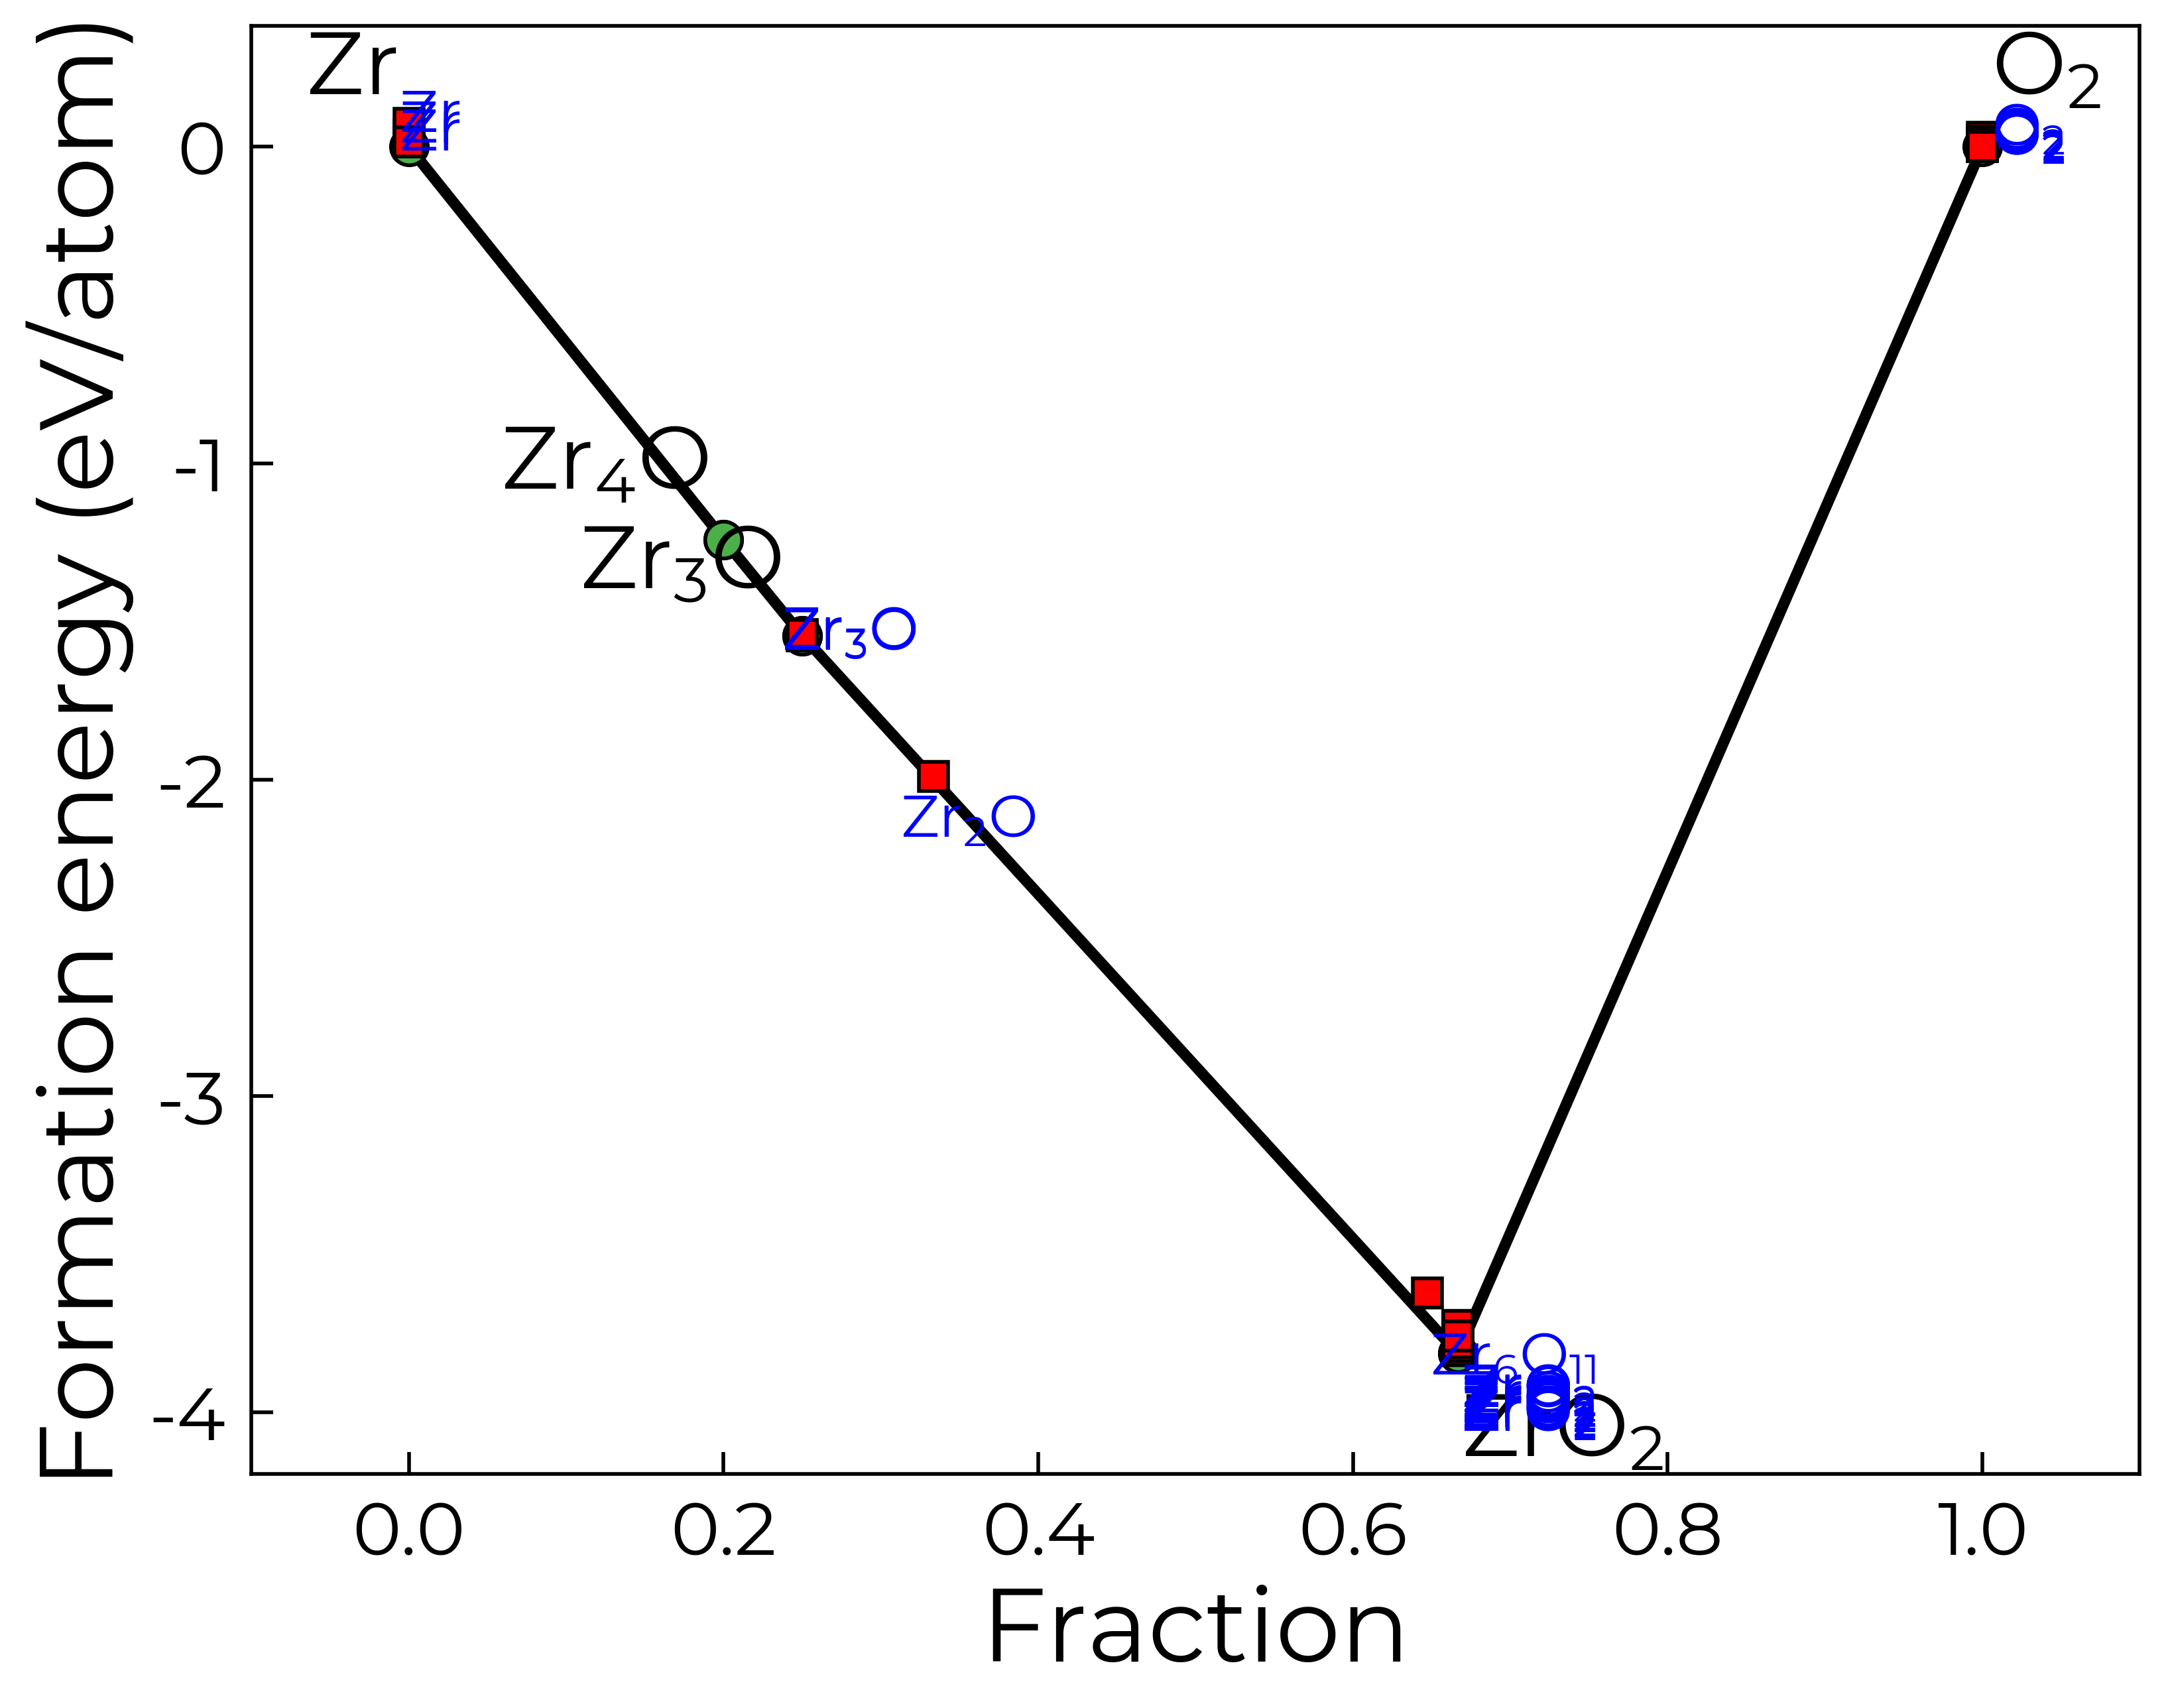

In [4]:
import doped
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.style.use(f"{doped.__path__[0]}/utils/doped.mplstyle")  # use doped style
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

system = ["Zr", "O"]  # system we want to get phase diagram for
mpr = MPRester()  # object for connecting to MP Rest interface, may need to specify API key here
entries = mpr.get_entries_in_chemsys(system)  # get all entries in the chemical system
pd = PhaseDiagram(entries)  # create phase diagram object
plotter = PDPlotter(pd, show_unstable=0.1, backend="matplotlib")  # plot phase diagram
plot = plotter.get_plot()

In this case, we see that there are many low-energy polymorphs of ZrO<sub>2</sub> on the MP database. If for example we had already calculated the different polymorphs of ZrO<sub>2</sub> and knew the MP-predicted groundstate (i.e. with MP-calculated energy above hull of zero) was indeed the groundstate with our chosen DFT setup, we could then remove the extra ZrO<sub>2</sub> phases here like so:

In [6]:
cp.entries = [entry for entry in cp.entries if entry.name != "ZrO2" or entry.data["energy_above_hull"] == 0]
print(len(cp.entries))
print([entry.name for entry in cp.entries])

10
['ZrO2', 'Zr', 'O2', 'Zr3O', 'Zr4O', 'Zr3O', 'Zr3O', 'Zr2O', 'Zr', 'Zr']


Similarly, if we had prior knowledge that the Materials Project data was accurate for our chosen host material, or were doing a high-throughput investigation where we were happy to sacrifice some accuracy/completeness for efficiency, we could set `e_above_hull` to zero (i.e. total confidence in the MP data):

In [7]:
cp = CompetingPhases("ZrO2", e_above_hull=0)
print(len(cp.entries))
print([entry.name for entry in cp.entries])

Retrieving ThermoDoc documents:   0%|          | 0/59 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

4
['ZrO2', 'Zr', 'O2', 'Zr3O']


Indeed, if we plot our phase diagram again, only showing the stable MP entries, we see that only Zr<sub>3</sub>O and O<sub>2</sub> border ZrO<sub>2</sub>, and so these (plus any remaining elements; i.e. Zr here) are the only competing phases generated with `e_above_hull = 0`:

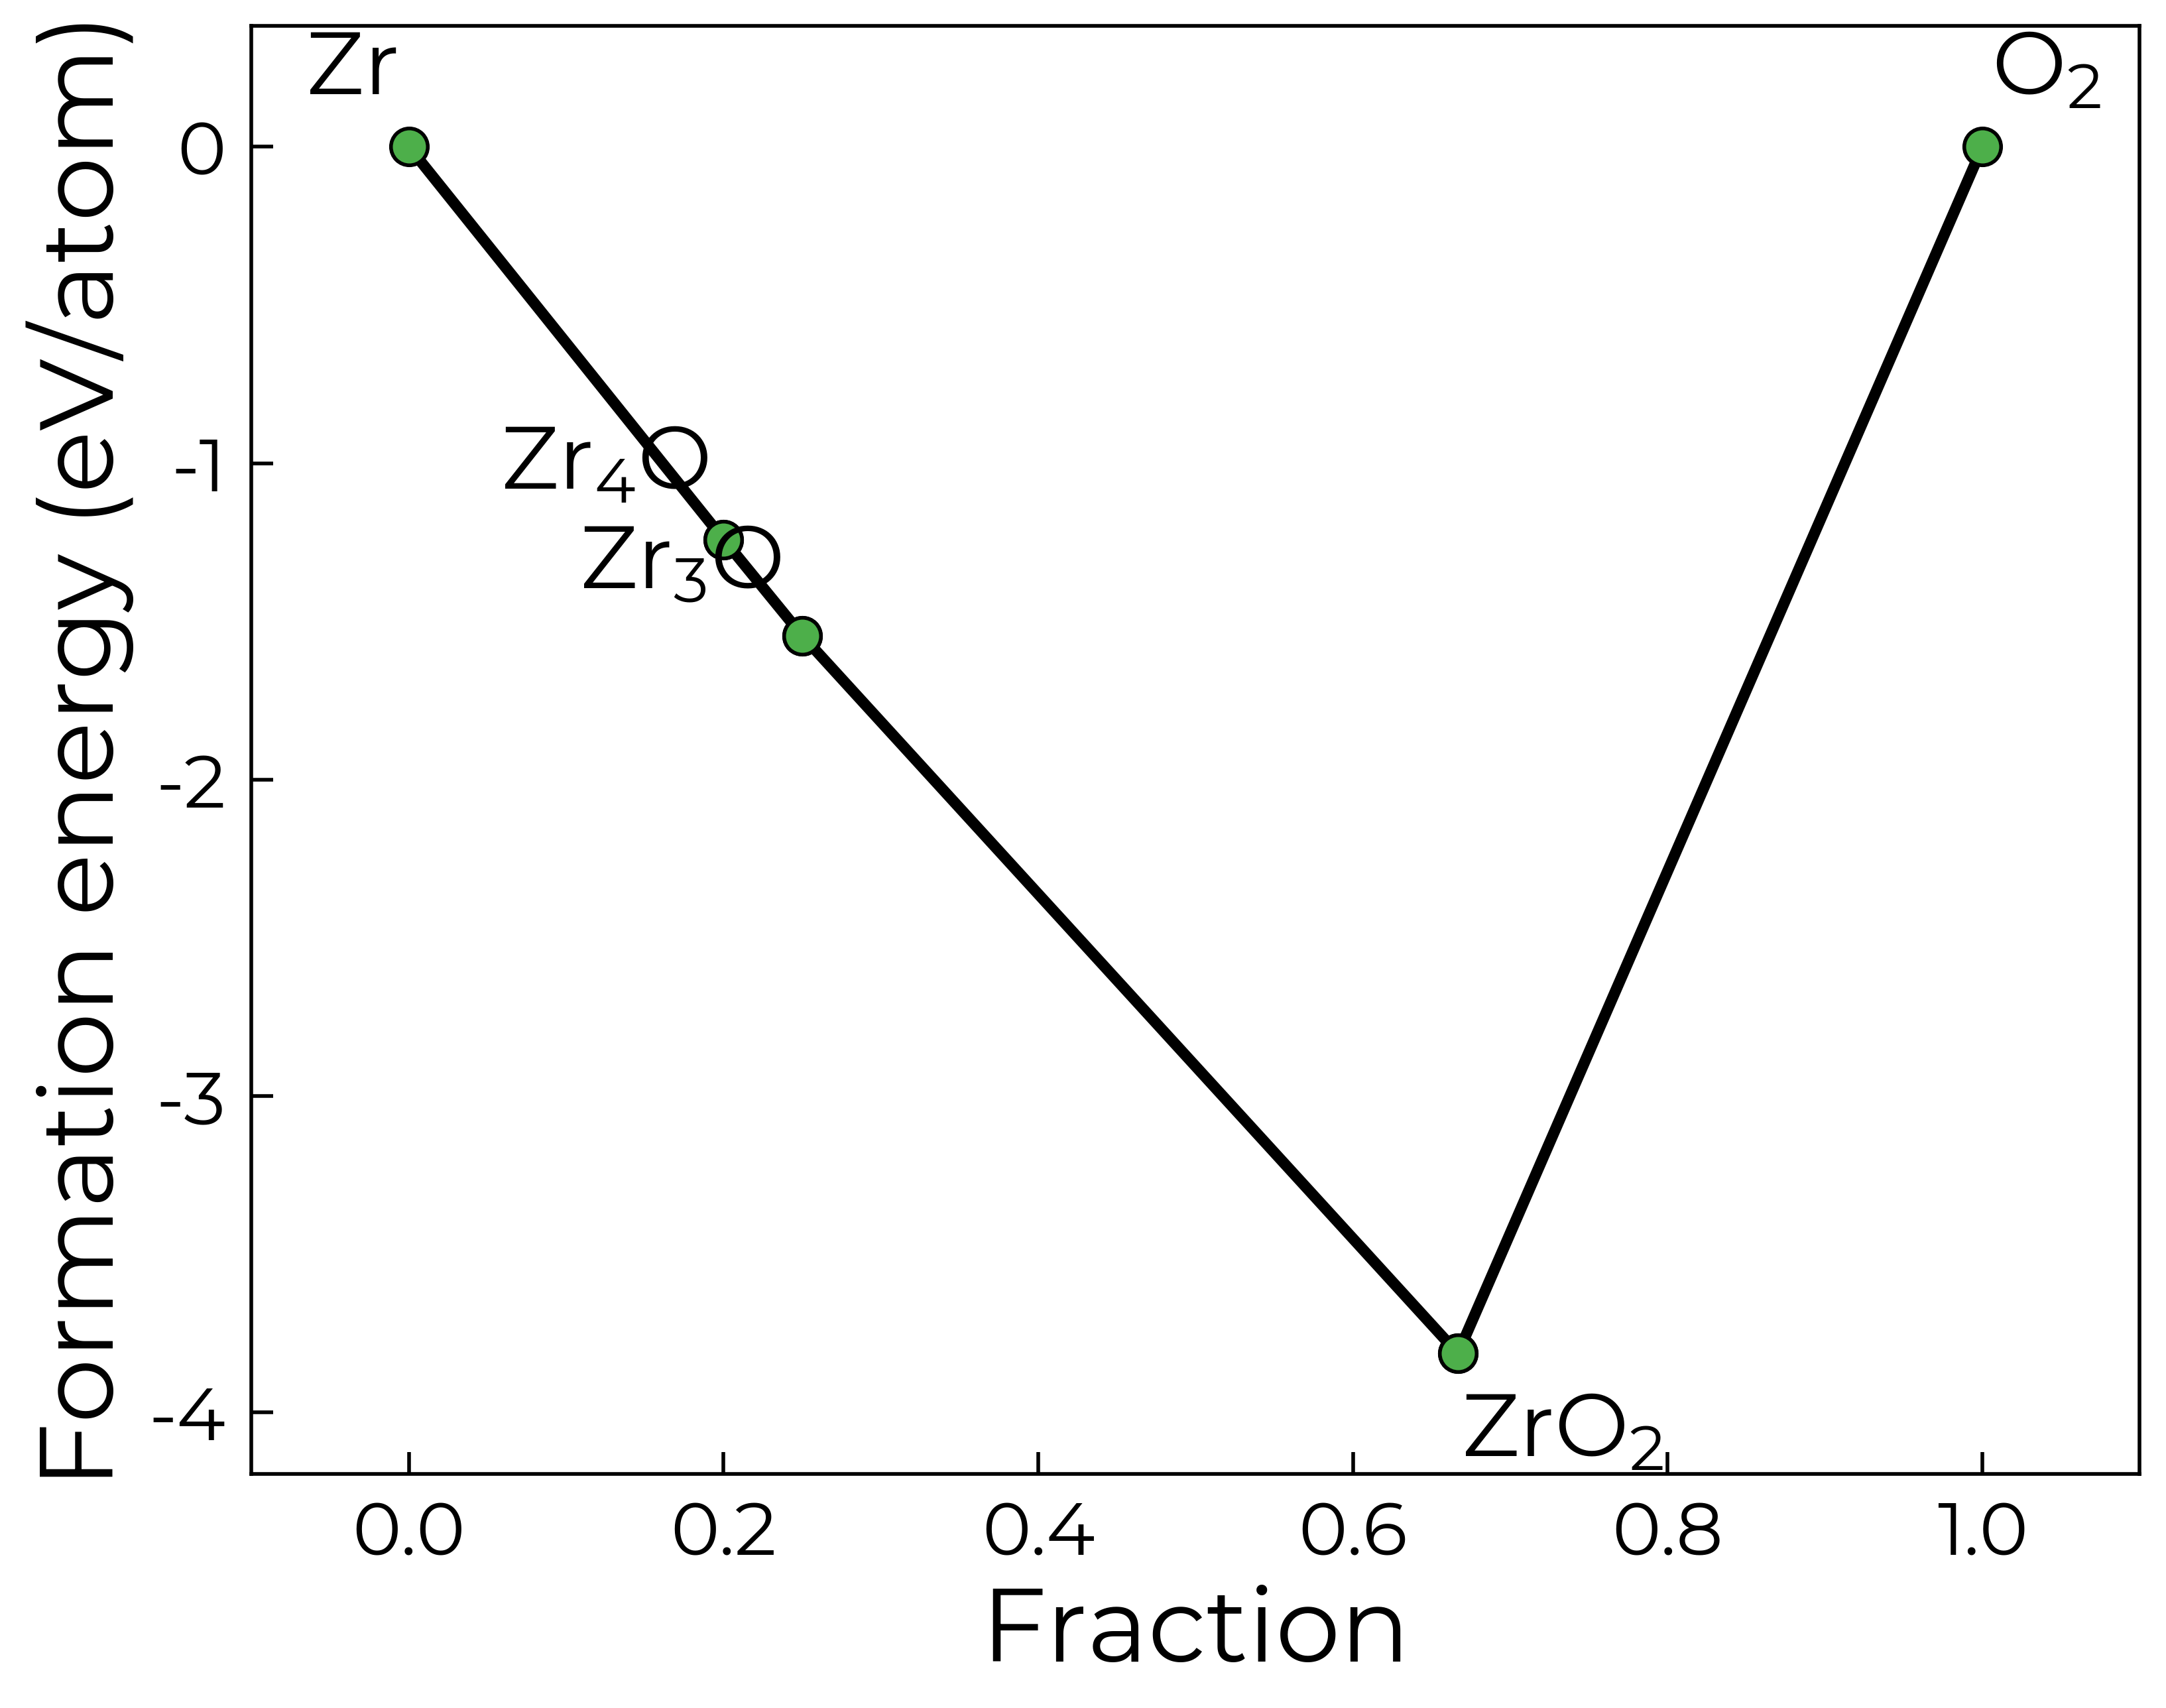

In [8]:
plotter = PDPlotter(pd, show_unstable=0, backend="matplotlib")  # plot phase diagram
plot = plotter.get_plot()

Just to illustrate, this is what our phase diagram would look like for a ternary system like Cu$_2$SiSe$_3$ ([a promising solar absorber](https://pubs.rsc.org/en/content/articlelanding/2023/ta/d3ta02429f)):

Retrieving ThermoDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

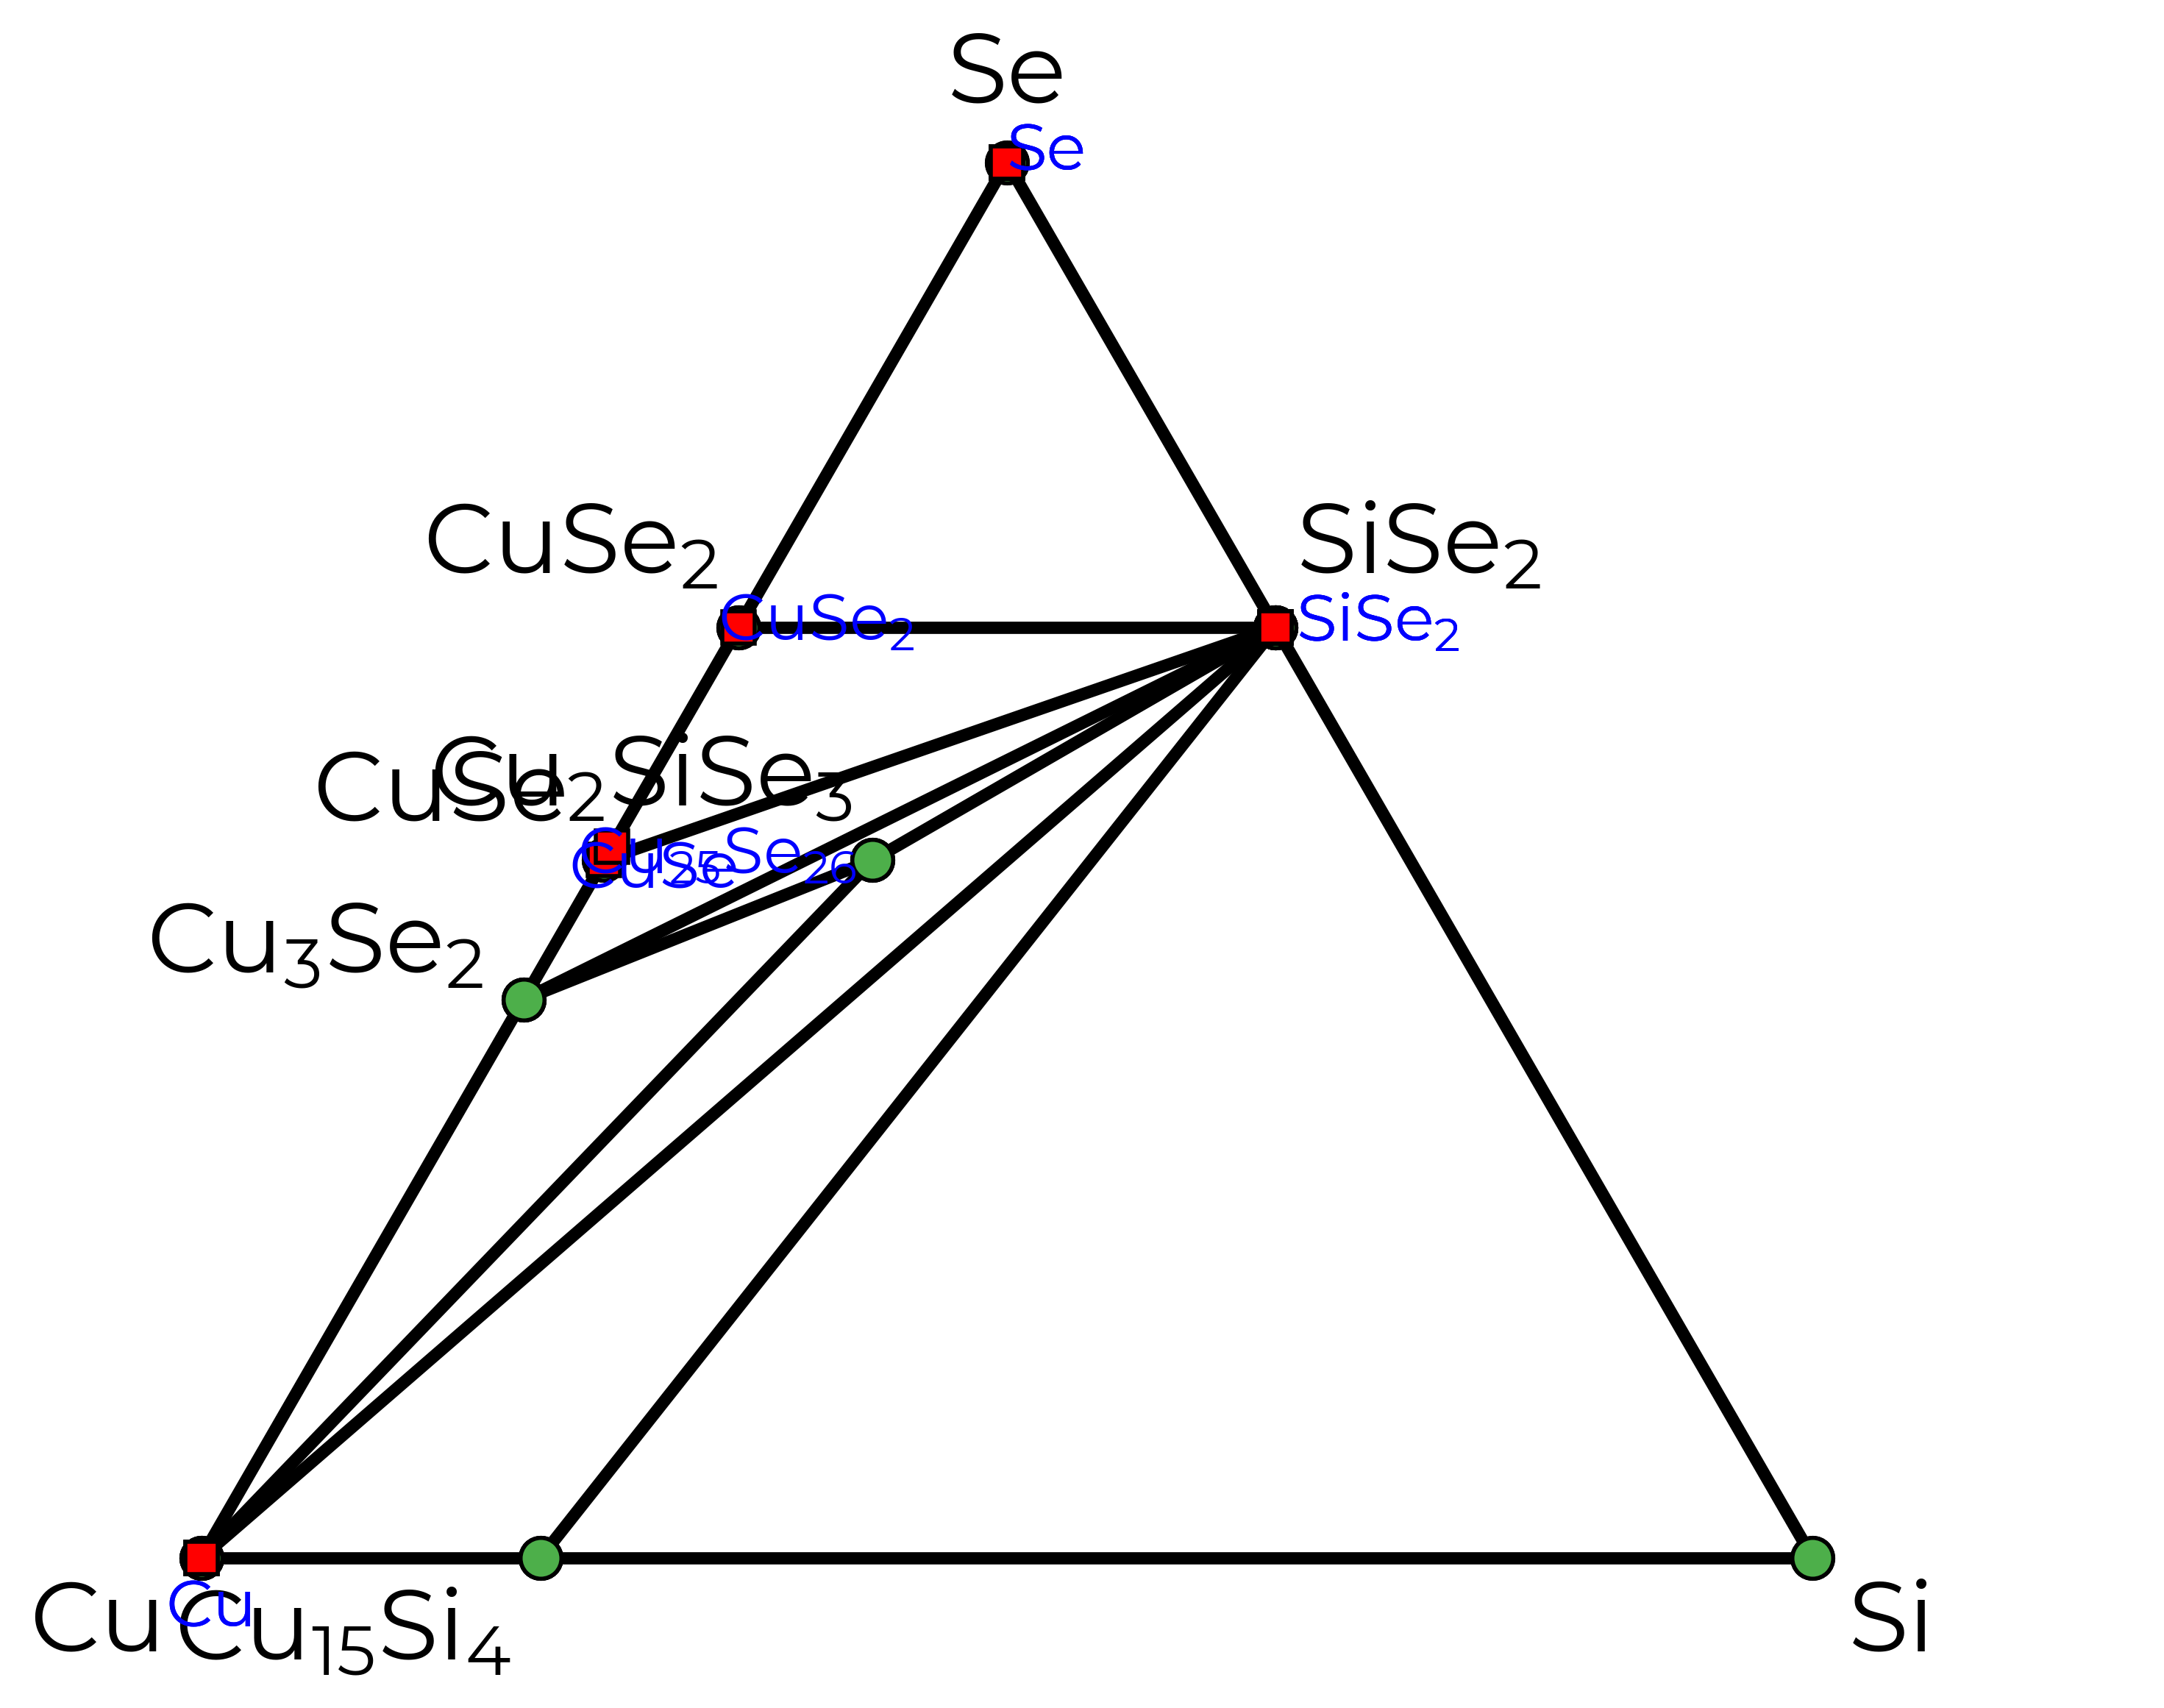

In [9]:
system = ["Cu", "Si", "Se"]  # system we want to get phase diagram for
mpr = MPRester()  # object for connecting to MP Rest interface, may need to specify API key here
entries = mpr.get_entries_in_chemsys(system)  # get all entries in the chemical system
pd = PhaseDiagram(entries)  # create phase diagram object
plotter = PDPlotter(pd, show_unstable=0.01, backend="matplotlib")  # plot phase diagram
plot = plotter.get_plot()

## Generating input files
We can then set up the competing phase calculations with `doped` as described below, or use the `pymatgen` `ComputedStructureEntry` objects in `cp.entries` to set these up in your desired format with `python` / [`atomate`](https://atomate.org/) / [`AiiDA`](https://www.aiida.net/) etc.

k-points convergence testing is done at GGA (PBEsol by default) and is set up to account for magnetic moment convergence as well. Here we interface with [vaspup2.0](https://github.com/kavanase/vaspup2.0) to make it easy to use on the HPCs (with the `generate-converge` command to run the calculations and `data-converge` to quickly parse and analyse the results).

You may want to change the default `ENCUT` (350 eV) or k-point densities that the convergence tests span (5 - 120 kpoints/Å<sup>3</sup> for semiconductors & insulators and 40 - 1000 kpoints/Å<sup>3</sup> for metals). Note that `ISMEAR` is set to `0` (gaussian smearing) for semiconductors & insulators and `2` (2nd order Methfessel-Paxton smearing) for metals by default, following the recommended choices in `VASP`, and k-point convergence testing is not required for molecules (Γ-point sampling is sufficient).

Note that `doped` generates "molecule in a box" structures for the gaseous elemental phases
H<sub>2</sub>, O<sub>2</sub>, N<sub>2</sub>, F<sub>2</sub> and Cl<sub>2</sub>. The molecule is placed in
 a slightly-symmetry-broken (to avoid metastable electronic solutions) 30 Å cuboid box, and relaxed with Γ-point-only k-point sampling.

The kpoints convergence calculations are set up with:

```{important}
If the _ground-state_ structure for your host composition is not listed on the `Materials Project` database (e.g. if you have a lower-symmetry lower-energy phase (common for perovskites for instance) or if it is a newly-discovered compound etc.), then you should use this structure for the competing phase energy calculation of your host composition (and, in most cases, for generating defect supercells), rather than the auto-generated `Materials Project` structure.
```

In [10]:
cp.convergence_setup(
    user_incar_settings={"GGA": "PE"}
)  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

Note that diatomic molecular phases, calculated as molecules-in-a-box (O2 in this case), do not require k-point convergence testing, as Γ-only sampling is sufficient.


```{note}
You may need to increase the default range of _k_-points to test convergence for certain systems, which can be controlled with the `kpoints_metals` and `kpoints_nonmetals` parameters for `cp.convergence_setup`.
```

```{tip}
_Usually_ we expect mostly equivalent energy convergence with respect to _k_-points / basis set for semi-local (GGA) and hybrid DFT. _**However,**_ this may not be the case when there is a major qualitative change in behaviour between semi-local/hybrid DFT, such as going from metallic at the GGA level to semiconducting with hybrid DFT – which can occur for relatively low band gap systems. In these cases, it can be worth performing the convergence tests with hybrid DFT to see if convergence is reached at lower _k_-point densities / basis set sizes.
```

In [15]:
!ls CompetingPhases/Zr3O_R32_EaH_0
!ls CompetingPhases/Zr3O_R32_EaH_0/kpoint_converge

kpoint_converge
k3,3,3 k4,4,4 k5,5,5 k6,6,6 k7,7,7 k8,8,8 k9,9,9


This creates a folder called `CompetingPhases` with all the relevant competing phases and k-point convergence test calculation directories. The naming format is `<Formula>_<Space Group Symbol>_EaH_<MP Energy above Hull>` ('EaH' stands for 'Energy above Hull'). These can be quickly run on HPCs using [vaspup2.0](https://github.com/kavanase/vaspup2.0), by creating a `job` file for the HPC scheduler (`vaspup2.0` example [here](https://github.com/kavanase/vaspup2.0/blob/master/input/job)), copying it into each directory and running the calculation with a `bash` loop like:

```bash
for i in *EaH*  # (in the competing_phases directory) – for each competing phase
do cp job $i/kpoint_converge
cd $i/kpoint_converge
for k in k*   # for each kpoint calculation directory
do cp job $k
cd $k
qsub job  # may need to change 'qsub' to 'sbatch' if the HPC scheduler is SLURM
cd ..
done
cd ../..
done
```

Within each competing phase directory in `CompetingPhases`, the `vaspup2.0` `data-converge` command can be run to quickly parse the results and determine the converged _k_-mesh (see the [vaspup2.0](https://github.com/kavanase/vaspup2.0) homepage for examples).

Next, you want to relax each competing phase with the converged k-point mesh, and calculate the energy with the same DFT functional and settings as your defect supercell calculations. `doped` can generate these folders for the relaxations of the competing phases.

The _k_-point meshes are Γ-centred Monkhorst-Pack by default. By default `doped` will
make the calculation inputs assuming a HSE06 `INCAR` (see [`HSESet.yaml`](https://github.com/SMTG-Bham/doped/tree/main/doped/VASP_sets/HSESet.yaml) for default values) and kpoint densities of 200 kpoints/Å<sup>3</sup> for metals and 64 kpoints/Å<sup>3</sup> for semiconductors/insulators. Assuming you've followed the k-point convergence testing workflow above, you should change the `KPOINTS` file to match the converged mesh in each case, however the default densities are good starting points. `doped` will automatically set `SIGMA` and `ISMEAR` accordingly depending on whether the phase is a semiconductor or metal, and will set `NUPDOWN` appropriately for molecules (i.e. O<sub>2</sub> has triplet spin).

These relaxations can be set up with:

In [16]:
cp.vasp_std_setup(
    user_incar_settings={"ENCUT": 600}
)  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

If you make a dictionary, as shown below, of the converged _k_-points for each competing phase, you can quickly generate the corresponding `KPOINTS` files for the relaxations like this:

In [18]:
from pymatgen.io.vasp.inputs import Kpoints

converged_kpoints_dict = {
    "Zr3O_R32_EaH_0": [2, 2, 2],
    "Zr_P6_3mmc_EaH_0": [11, 11, 11],
    "ZrO2_P2_1c_EaH_0": [8, 8, 8],
}  # etc...

for name, kpts in converged_kpoints_dict.items():
    kpoints = Kpoints.gamma_automatic(kpts=kpts)
    kpoints.write_file(f"CompetingPhases/{name}/vasp_std/KPOINTS")

In [19]:
!ls CompetingPhases/Zr3O_R32_EaH_0
!ls CompetingPhases/Zr3O_R32_EaH_0/vasp_std

kpoint_converge vasp_std
INCAR   KPOINTS POSCAR  POTCAR


Remember that the final `ENCUT` used for the energy calculations should be the same as for your host
material & defects, and that you may still need to account for Pulay stress by increasing `ENCUT` for
the geometry relaxations (a typical rule of thumb being 1.3*converged `ENCUT`) or re-relaxing each
structure until the volume change is minimal (roughly <0.3%). This is not a concern for the
molecule-in-a-box competing phases, due to the large simulation box size and fixed volume.

```{tip}
For hybrid DFT competing phase relaxations, it is often a good idea to use the [`NKRED(X,Y,Z)`](https://www.vasp.at/wiki/index.php/NKRED) `INCAR` tag(s), which reduce the _k_-point grid used in the Fock exchange potential by the factor specified, to speed up the calculations while retaining good accuracy. Note that `NKRED(X,Y,Z)` needs to divide into the number of _k_-points in the corresponding direction. Typically `NKRED(X,Y,Z)` has a greater effect on energy rather than force accuracy, and so it is often useful to use `NKRED(X,Y,Z)` values of `2` – or possibly `3` for high _k_-point densities – to pre-converge the structure relaxation, before then continuing the calculations without `NKRED(X,Y,Z)` for the final energy; which often then only requires one or two ionic steps. 

`NKRED(X,Y,Z)` is particularly useful for metals, where overall dense _k_-point grids are required, but the Fock exchange contribution typically converges at much lower _k_-point densities. In such cases, `NKRED(X,Y,Z)` can be used to greatly reduce the computational cost with minimal loss of accuracy. A further relaxation/energy calculation without `NKRED(X,Y,Z)` may not be required in these cases, but it is good practice to check the accuracy by comparing the energies of the same structure with and without `NKRED(X,Y,Z)`.
```

### Extrinsic Competing Phases

If you're investigating extrinsic impurities/doping in your system, you also need to calculate the chemical potentials for these extrinsic species, which can be done using `doped` in a similar fashion as for the intrinsic species:

In [20]:
from doped.chemical_potentials import ExtrinsicCompetingPhases

In [21]:
ex_cp = ExtrinsicCompetingPhases(composition="ZrO2", extrinsic_species="La", e_above_hull=0.03)

Retrieving ThermoDoc documents:   0%|          | 0/59 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/82 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
len(ex_cp.entries)
print([entry.name for entry in ex_cp.entries])

['La', 'La2Zr2O7', 'La']


The same competing phase generation algorithm as described above is used for extrinsic competing phases, ensuring no unnecessary additional phases are generated.

The setup for convergence testing and relaxations is done in the exact same way as before:

In [23]:
ex_cp.convergence_setup(
    user_incar_settings={"ENCUT": 550}
)  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

In [24]:
!ls CompetingPhases/La2Zr2O7_Fd-3m_EaH_0
!ls CompetingPhases/La2Zr2O7_Fd-3m_EaH_0/kpoint_converge

kpoint_converge
k1,1,1 k2,2,2 k3,3,3 k4,4,4


In [25]:
ex_cp.vasp_std_setup(
    user_incar_settings={"ENCUT": 550}
)  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

In [26]:
!ls CompetingPhases/La2Zr2O7_Fd-3m_EaH_0
!ls CompetingPhases/La2Zr2O7_Fd-3m_EaH_0/vasp_std

kpoint_converge vasp_std
INCAR   KPOINTS POSCAR  POTCAR


## Parsing Competing Phases

### Read in data from `vasprun.xml(.gz)` files

Once you've calculated your competing phases, you will want to parse the results to determine the chemical potential limits of your host material. To do this, we need to parse the `vasprun.xml(.gz)` files from your final
production-run competing phase calculations. To download the `vasprun.xml(.gz)` files from the HPCs recursively, you can recursively `rsync`:

```bash 
rsync -azvuR hpc:'path/to/the/base/folder/competing_phases/./*_EaH_*/vasp_std/vasprun.xml*' .
```

where the `/./` indicates where you'd like to start the recurse from, so you only keep the folder structure from the `formula_EaH_*` point onwards. If you've done spin-orbit coupling (SOC) calculations with results in `vasp_ncl` folders, then you need to change `vasp_std` to `vasp_ncl` above, or to whatever name you've given the production-run folders. Note that you can compress the `vasprun.xml` files to save space (with e.g. `find . -name vasprun.xml -exec gzip {} \;`) and these will still be parsed fine by `doped`.

All analysis is performed with the `CompetingPhasesAnalyzer` class, and all you need to supply it is the formula of your host system and the path to the base folder in which you have all your `formula_EaH_*/vasp_std/vasprun.xml(.gz)` files.

In [1]:
from doped.chemical_potentials import CompetingPhasesAnalyzer

# in this case we have our competing phases (<formula>_<spg>_EaH_<eah> folders)
# in the ZrO2_CompetingPhases folder:
cpa = CompetingPhasesAnalyzer(composition="ZrO2", entries="ZrO2_CompetingPhases")

Parsing vaspruns...: 100%|██████████| 8/8 [00:00<00:00, 86.50it/s]


```{note}
The `CompetingPhasesAnalyzer` input is quite flexible, we can alternatively input a list of paths to `vasprun.xml(.gz)` files to parse, or `pymatgen` `ComputedEntry`/`ComputedStructureEntry` objects directly (e.g. if we were using high-throughput computing architectures such as `atomate2` or `AiiDA`). As always, see the docstring and python API docs for more info!
```

The computed chemical potential limits, which can then be used for determining the defect formation energies with `doped` (i.e. with the `DefectThermodynamics` plotting & analysis methods) are stored in the `chempots` attribute:

In [2]:
cpa.chempots

{'limits': {'ZrO2-O2': {'Zr': -20.8191, 'O': -7.0066},
  'Zr3O-ZrO2': {'Zr': -10.04322, 'O': -12.39454}},
 'elemental_refs': {'O': -7.0066, 'Zr': -9.84368},
 'limits_wrt_el_refs': {'ZrO2-O2': {'Zr': -10.97543, 'O': 0.0},
  'Zr3O-ZrO2': {'Zr': -0.19954, 'O': -5.38794}}}

and a summarized version is given by the ``chempots_df`` ``DataFrame``:

In [3]:
cpa.chempots_df

,Zr,O
Limit,,
ZrO2-O2,-10.97543,0.00000
Zr3O-ZrO2,-0.19954,-5.38794


Here, the compositions listed under `Limit` are the competing phases which are in equilibrium with the host/bulk material at the given point in the phase diagram, which corresponds to a vertex on the chemical stability region of the host – i.e. corresponding to a chemical potential limit for the host material.
In other words, it represents an extremal point in the hyperplane of chemical potentials in which the host compound is stable. Thus in this case the "ZrO2-O2" limit corresponds to the oxygen-rich chemical potential limit, corresponding to the maximum oxygen chemical potential at which the host (ZrO2) is stable – in this case being in equilibrium with elemental $O_2$. Likewise "Zr3O-ZrO2" represents the Zr-rich limit, where the Zr chemical potential is maximised (under the constraint of the host material being stable with respect to decomposition).

```{tip}
The keys in the `'limits'` and `'limits_wrt_el_refs'` sub-dictionaries in the ``chempots`` dict list the competing phases at the given chemical potential limit, while `'elemental_refs'` gives the computed reference energies per atom of the elemental phases (used to obtain the formal chemical potentials, which are referenced to the energies of the elements in their standard states).
```

```{important}
The `chempots` dict is the format used by `doped` for inputting chemical potentials to `DefectThermodynamics` (or its methods) for plotting and analysis.
```

It is usually convenient to save the `chempots` dict to file, so that we can use it with our `DefectThermodynamics` analysis in a different notebook / environment, which we can do with `dumpfn`:

In [28]:
from monty.serialization import dumpfn, loadfn

dumpfn(cpa.chempots, "ZrO2_CompetingPhases/zro2_chempots.json")

# then to reload later, we can use:
zro2_chempots = loadfn("ZrO2_CompetingPhases/zro2_chempots.json")

### Analysing and visualising the chemical potential limits
There are a number of ways we can visualize the calculated chemical potential limits:

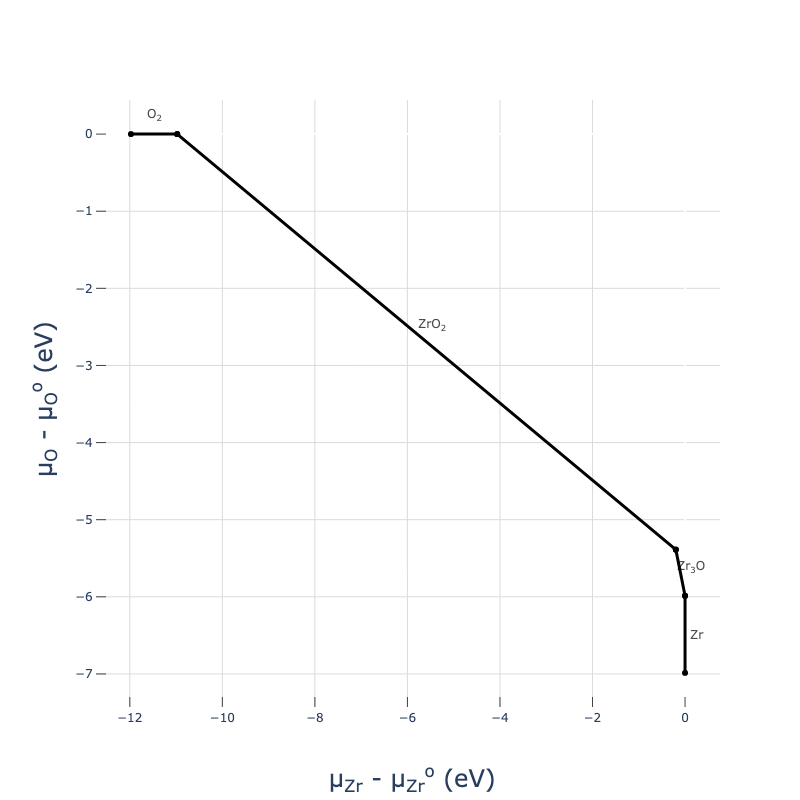

In [30]:
from pymatgen.analysis.chempot_diagram import ChemicalPotentialDiagram

cpd = ChemicalPotentialDiagram(cpa.intrinsic_phase_diagram.entries)
plot = cpd.get_plot()
plot.show("png", dpi=400)

 Because `cpd.get_plot()` returns a `plotly` object, it's almost infinitely customisable using `plot.update_scenes()` - you can change colours, fonts, axes and even data after it's been plotted. See the [docs](https://plotly.com/python/) for more info.

Beware that because we only generated the relevant competing phases on the `Zr-O` phase diagram for our ZrO<sub>2</sub> host material, we have not calculated _all_ phase in the `Zr-O` chemical space (just those that are necessary to determine the chemical potential limits of ZrO<sub>2</sub>), and so these chemical potential diagram plots are only accurate in the vicinity of our host material.

This is an example of what this looks like for a higher-dimensional quaternary system:

In [31]:
from monty.serialization import loadfn

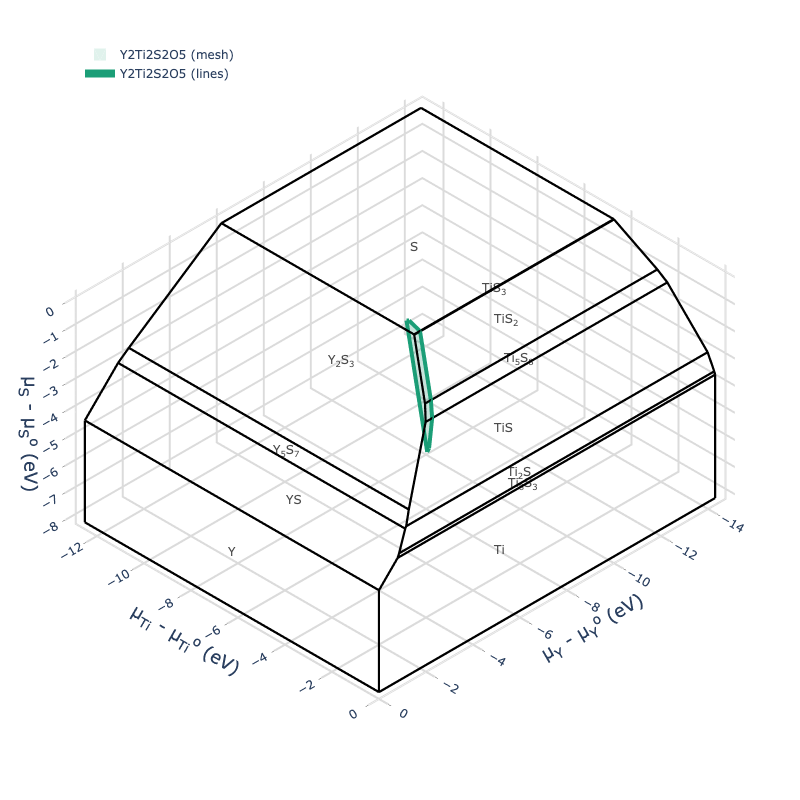

In [32]:
cpd = ChemicalPotentialDiagram(loadfn("YTOS/ytos_phase_diagram.json").entries)
plot = cpd.get_plot(formulas_to_draw=["Y2Ti2S2O5"])
plot.show("png", dpi=400)

We can also get a ``DataFrame`` summary of the formation energies of all parsed competing phases:

In [2]:
cpa.get_formation_energy_df()  # there is also the prune_polymorphs option here to only show the lowest energy structures for each composition, as well as include_dft_energies, and skip_rounding

,Space Group,Energy above Hull (eV/atom),Formation Energy (eV/fu),Formation Energy (eV/atom),k-points
Formula,,,,,
ZrO2,P2_1/c,0.000,-10.975,-3.658,3x3x3
Zr,P6_3/mmc,0.000,0.000,0.000,9x9x5
O2,P4/mmm,0.000,0.000,0.000,2x2x2
Zr3O,R-3c,0.000,-5.987,-1.497,5x5x5
ZrO2,Pbca,0.008,-10.951,-3.650,3x3x1
Zr3O,P6_322,0.013,-5.935,-1.484,5x5x5
Zr2O,P312,0.019,-5.729,-1.910,5x5x2
Zr,Ibam,0.025,0.025,0.025,6x6x6


### Parsing Extrinsic (Dopant) Competing Phases

If we have generated and calculated competing phases for extrinsic species (i.e. to obtain the chemical potential limits for dopants/extrinsic impurities in our host system), we can parse them in the same manner with `CompetingPhasesAnalyzer`:

In [3]:
la_cpa = CompetingPhasesAnalyzer(
    composition="ZrO2",  # same host composition
    entries="La_ZrO2_CompetingPhases",  # folder with our competing phase calculations (incl extrinsic)
)

Parsing vaspruns...: 100%|██████████| 11/11 [00:00<00:00, 88.67it/s]


As before, we can get the chemical potential limits in the format required for the `DefectThermodynamics` plotting and analysis methods using `cpa.chempots`, which can be easily dumped to a reusable `json` file for later use:

In [34]:
from monty.serialization import dumpfn, loadfn

dumpfn(la_cpa.chempots, fn="La_ZrO2_CompetingPhases/zro2_la_chempots.json")
la_chemlims = loadfn("La_ZrO2_CompetingPhases/zro2_la_chempots.json")

and we can quickly view the chemical potential limits with `chempots_df`:

In [4]:
la_cpa.chempots_df

,Zr,O,La,La-Limiting Phase
Limit,,,,
ZrO2-O2,-10.97543,0.00000,-9.462986,La2Zr2O7
Zr3O-ZrO2,-0.19954,-5.38794,-1.381086,La2Zr2O7


`CompetingPhasesAnalyzer` can likewise parse and compute the chemical potential limits with multiple extrinsic species present.

## Summarising & Saving Results for Publication

Often we may want to summarise the results of our competing phases and chemical potential limit calculations, to include in the SI of journal articles or theses to aid open-science and reproducibility, or for quick data sharing, or for use with other codes. There are a number of simple methods for achieving this with the `CompetingPhasesAnalyzer` class and properties.

### Save Formation Energies and Chemical Potentials to File

As shown above, we can get `DataFrame` summaries of the formation energies of our calculated competing phases, and the computed chemical potential limits using ``CompetingPhasesAnalyzer.get_formation_energy_df()`` and ``CompetingPhasesAnalyzer.chempots_df`` respectively. These `DataFrame`s can be saved to file with the `DataFrame.to_csv()` method, which we can then import as a table in `Microsoft Word` or convert to `LaTeX` format with [www.tablesgenerator.com/latex_tables](https://www.tablesgenerator.com/latex_tables):

In [18]:
# e.g. here as an example I get the formation energy dataframe, include the DFT energies,
# remove the 'eV/atom' columns, and only include the lowest energy polymorph for each phase
form_energy_df = cpa.get_formation_energy_df(prune_polymorphs=True, include_dft_energies=True)
form_energy_df = form_energy_df.drop(columns=[col for col in form_energy_df.columns if "eV/atom" in col])
form_energy_df

,Space Group,Formation Energy (eV/fu),DFT Energy (eV/fu),k-points
Formula,,,,
ZrO2,P2_1/c,-10.975,-34.832,3x3x3
Zr,P6_3/mmc,0.000,-9.844,9x9x5
O2,P4/mmm,0.000,-14.013,2x2x2
Zr3O,R-3c,-5.987,-42.524,5x5x5
Zr2O,P312,-5.729,-32.423,5x5x2


In [8]:
form_energy_df.to_csv("ZrO2_Competing_Phase_Formation_Energies.csv")  # save to csv file

We could also do the same with ``CompetingPhasesAnalyzer.chempots_df``.

### Print Formation Energies as a `LaTeX` Table
We also provide the `to_LaTeX_table` method to directly convert the parsed formation energies into a LaTeX table, either as a one- or two-column table; ordered alphabetially or in descending order of energies:

In [4]:
cpa.to_LaTeX_table()  # we can then copy and paste this into LaTeX

\begin{table}[h]
\centering
\caption{Formation energies per formula unit ($\Delta E_f$) of \ce{ZrO2} and all competing phases, with k-meshes used in calculations. Only the lowest energy polymorphs are included}
\label{tab:competing_phase_formation_energies}
\begin{tabular}{ccc}
\hline
Formula & k-mesh & $\Delta E_f$ (eV/fu) \\ \hline 
\ce{ZrO2} & 3$\times$3$\times$3 & -10.975 \\ 
\ce{O2} & 2$\times$2$\times$2 & 0.000 \\ 
\ce{Zr} & 9$\times$9$\times$5 & 0.000 \\ 
\ce{Zr2O} & 5$\times$5$\times$2 & -5.729 \\ 
\ce{Zr3O} & 5$\times$5$\times$5 & -5.987 \\ 
\hline
\end{tabular}
\end{table}


```{note}
The table does not use `booktabs` by default but you can change the horizontal lines (`hline`) to
toprule, midrule and bottomrule to get the desired style effect. The output also relies on using the
`\ce{}` command from the `mhchem` LaTeX package to get the correct formatting for the chemical formulae.
```